# Process BSweeps

## Setup Environment

In [1]:
%clear
%matplotlib inline
import os
import sys

sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents', 'PhD', 'root', 'lib'))


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d

# The following is bad practice, but it works for me for now.
from MiscFunctions import save_figure
from SuperconductivityCalculations import (mean_free_path, monotonic_background, lp_oscillations)

from peakdetect import peakdetect

from Constants import PHI_0, AL_ELECTRON_DENSITY, AL_FERMI_VELOCITY
from Helper_Mod import (load_sweep_data, save_data)
from Locations import (HOME, DATA_DIR, RAW_DIR, RESULTS_DIR, DOCS_DIR)

sns.set_context("talk", font_scale=1.25, rc={"lines.linewidth": 1.5})
sns.set_style("whitegrid")

## Select Sample

| Sample Name | Selectable Networks | Measurement Runs |
|-------------|----------|-|
| SiO2Al002 | 2d, 2e | cooldown-2012-04-12, cooldown-2015-05-04(bt_sweep01, tb_sweep01, tb_sweep02) |
| omri01 | None | 2013-04-09 |
| omri21 | None | 2013-09-25 |
| SiO2Al122 | None | 2013-12-04 |
| SiO2Al149 | None | 2014-02-14, 2014-07-03 | 
| SiO2Al143 | None | 2014-07-04 |
| LOT12 | None| 2014-12-01 |
| LOS001 | None | 2015-02-06 | 
| LOS003| None| 2015-03-31, 2015-05-13, 2015-05-18 |


In [2]:
sample_name = 'sio2al002'
sample_network = '2d'
sample_run = 'cooldown-2012-04-12'
sample_name = os.path.join(sample_name, sample_network)
sample_directory = os.path.join(DATA_DIR, sample_name, 'cryo_measurements')
sample_results = os.path.join(RESULTS_DIR, sample_name, 'cryo_measurements')
print(os.path.exists(sample_directory), os.path.exists(sample_results)) #, sample_data)

True True


## Load Data

In [3]:
df = load_sweep_data('bsweep', sample_dir=sample_directory, sample_run=sample_run, root='proc02')
#df.keys()

In [4]:
for key in sorted(df.keys()):
    print(key) #, ':', df[key]['filename'])
#     print('\t', list(df[key]['ADWin'].keys()))
# df_extra

0256mK up 01
0267mK down 01
1067mK down 01
1071mK up 01
1132mK down 01
1137mK up 01
1147mK down 01
1156mK up 01


## Process Data

In [5]:
if sample_name in ['sio2al002/2d']:
    res_device = 'all'
else:
    res_device = 'ADWin'
print(res_device)

all


### Adjust BField Scaling Problems

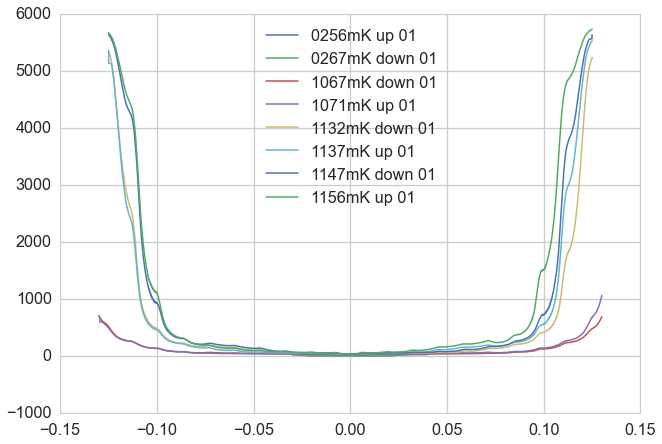

In [6]:
if sample_name in ['sio2al002/2d']:
    fig_adjust, ax_adjust = plt.subplots()

    for key in sorted(df.keys()):

        if df[key][res_device]['BField'][-1] > 0.5:
            print('Adjusting BField of', key)
            #df[key]['all']['BField'] = df[key]['all']['BField'] / 1000
            #df[key]['modified'] = True
            #df[key]['mods'].append('Adjusting BField scaling.')

        temp_df = df[key]['all']



        x = temp_df['BField']
        y = temp_df['RSample']

        ax_adjust.plot(x, y, label=key)

    ax_adjust.legend(loc='best');

### Add normalized Resistance and $\Delta dR$

In [40]:
if sample_name == 'sio2al002/2d':
    normal_resistance = 6316
    resistance_offset = 331.6
    dR_key = 'RSample'
    ddR_key = r'$R/R_N$'
    TSample_key = 'THe3'
    B_key = 'BField'

In [8]:
for key in sorted(df.keys()):
    if ddR_key not in df[key]['all']:
        print('Adjusting resistance and calculating normalized resistance for', key)
        df[key][res_device][ddR_key] = (df[key][res_device][dR_key] - resistance_offset) / normal_resistance
        df[key]['mods'].append('Adding normalized resistance.')
        df[key][res_device][dR_key] -= resistance_offset
        df[key]['mods'].append('Removing resistance offset, i.e. cable resistance (2-point).')
        df[key]['modified'] = True

### Add Total Flux and Number of Flux Quanta

In [9]:
if sample_name == 'sio2al002/2d':
    r = 400
    factor = 1000

In [10]:
for key in sorted(df.keys()):
    if '$\Phi$' not in df[key]['all']:
        df[key]['all'][r'$\Phi$'] = df[key]['all']['BField'] * factor * r ** 2
        df[key]['mods'].append(r'Calculating and adding $\Phi$. r = {:.3f} nm'.format(r))
        print(r'Added $\Phi$ base on B for measurement {}.'.format(key))
        df[key]['all'][r'$\Phi / \Phi_0$'] = df[key]['all'][r'$\Phi$'] / PHI_0
        df[key]['mods'].append(r'Calculating and adding $\Phi$.')
        df[key]['modified'] = True

## Save All New Processed Data

First see what's going to be saved

In [11]:
for key in sorted(df.keys()):
    if df[key]['modified']:
        print(key)
        for mod in df[key]['mods']:
            print('\t', mod)

Now actually save it

In [12]:
save_data(df, sample_directory, sample_run, root='proc02', overwrite=False)

Remove the modified flag on all data.
NOTE: Only do this if the data was saved successfully!

In [13]:
for key in sorted(df.keys()):
    df[key]['modified'] = False

## Plot the dR vs B for all sweeps

Determine the scaling of the colors based on the number of lines to plot

In [14]:
sns.set_palette("coolwarm_r", len(df.keys()))
sns.set_context("talk", font_scale=1.25, rc={"lines.linewidth": 1.5})

### Plot Full Range

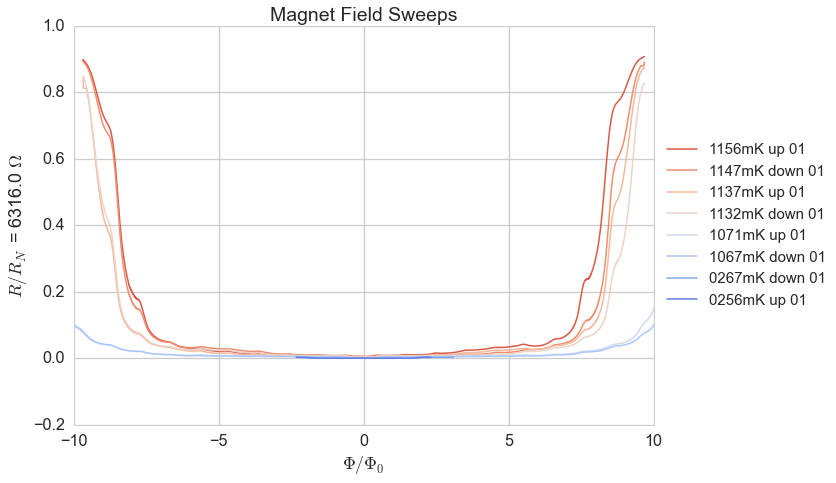

In [15]:
fig01, ax01 = plt.subplots();

legend_entry = []

for key in sorted(df.keys())[::-1]:
    temp_df = df[key][res_device]
    
    x = temp_df['$\Phi / \Phi_0$']
    #x = temp_df['BField']
    y = temp_df['$R/R_N$']
    #y = temp_df['RSample']
    
    ax01.plot(x, y)
    legend_entry.append(key)

        
ax01.legend(legend_entry, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, prop={'size':15});

ax01.set_xlim(-10, 10)

ax01.set_ylabel(r'$R / R_N$ = {res:.1f} $\Omega$'.format(res=normal_resistance));
ax01.set_xlabel(r'$\Phi / \Phi_0$');

ax01.set_title('Magnet Field Sweeps');

In [16]:
save_figure(fig01, '00-BSweeps.png', sample_name, sample_run, dpi=180);

### Plot Zoomed In Range

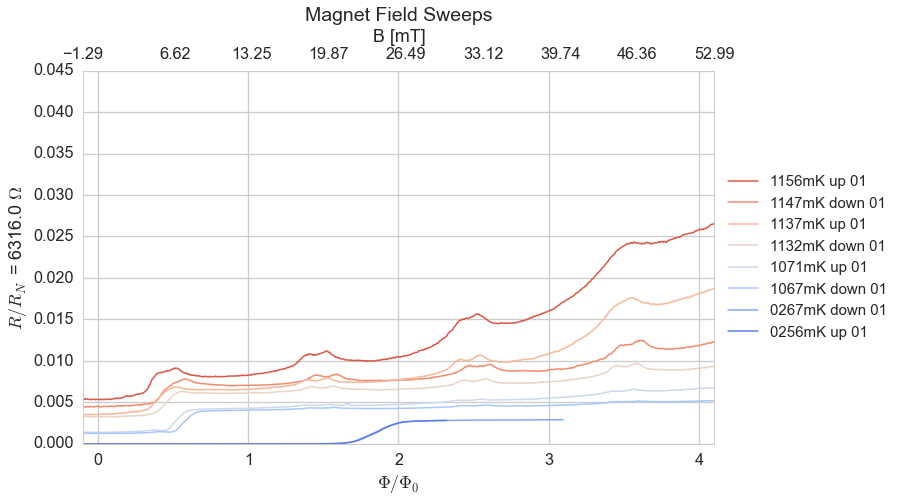

In [32]:
fig02, ax02 = plt.subplots();

legend_entry = []

for key in sorted(df.keys())[::-1]:
    
    temp_df = df[key][res_device][df[key][res_device]['$\Phi / \Phi_0$'] >= -0.2]
    
    x = temp_df['$\Phi / \Phi_0$']
    
    y = temp_df[ddR_key]
    
    ax02.plot(x, y)

    legend_entry.append(key)
        
ax02.legend(legend_entry, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, prop={'size':15});

ymin = 0.0
ymax = 0.045

ax02.set_ylim(ymin, ymax)

xmin = -0.1
xmax = 4.1

bmin = xmin * PHI_0 / r**2
bmax = xmax * PHI_0 / r**2
ax02.set_xlim(xmin, xmax);
ax02_B = ax02.twiny();
ax02_B.set_xlim(bmin, bmax);
ax02_B.grid(False)
ax02_B.set_xlabel('B [mT]')

bticks = np.hstack((xmin, np.linspace(0, xmax, xmax / 0.5 + 1))) * PHI_0 / r**2

ax02_B.set_xticks(np.delete(bticks, [1]))

ax02.set_xlabel(r'$\Phi / \Phi_0$');
ax02.set_ylabel(ddR_key + ' = {res:.1f} $\Omega$'.format(res=normal_resistance));

ax02_B.set_title('Magnet Field Sweeps', y=1.12);


fig02.tight_layout()

In [34]:
save_figure(fig02, '01-BSweeps_zoomed.png', sample_name, sample_run, dpi=180);

## Plot dR vs T

[ 1.156  1.147  1.137  1.132  1.071  1.067  0.267  0.256]


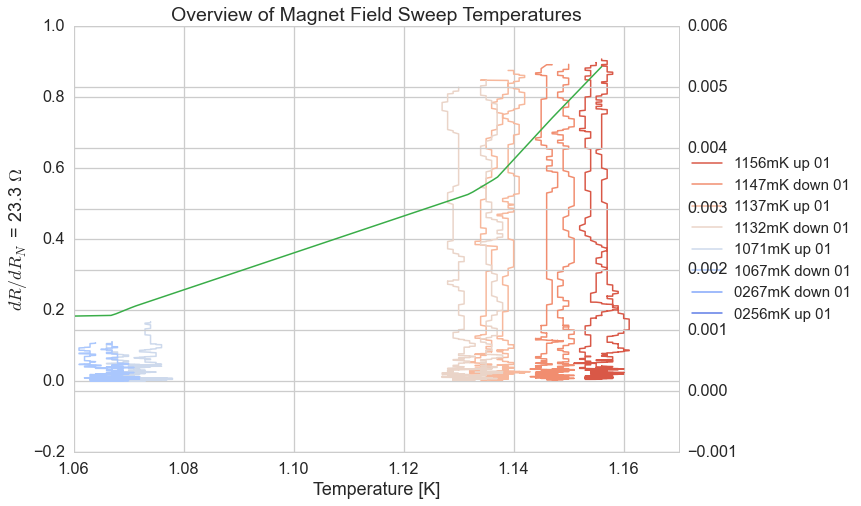

In [54]:
fig_cur01, ax_cur01 = plt.subplots();

legend_entry = []

dR = []
T = []

# Plot dR vs T for each magnetfield sweep and collect the average temperature and resistance at B=0
for key in sorted(df.keys())[::-1]:

    temp_df = df[key][res_device]
    
    temp = int(key.split('mK')[0])/1000
    
    x = temp_df[TSample_key]
    
    y = temp_df[ddR_key]
    
    ax_cur01.plot(x,y)
    
    B = temp_df[B_key]
    
    T.append(np.round(temp_df[TSample_key].mean(), 3))
    
    idx = np.abs(B).argmin()
    
    dR.append(temp_df[ddR_key][idx])
    
    legend_entry.append(key)

T = np.array(T)
print(T)
dR = np.array(dR)

f = interp1d(T, dR)

xnew = np.linspace(min(T), max(T), 1000);
ynew = f(xnew)
ddRdT = np.diff(ynew)/np.diff(xnew)
idx_tc = np.abs(ynew - 0.5 * normal_resistance).argmin()
Tc = xnew[idx_tc]

ax_cur02 = ax_cur01.twinx()
ax_cur02.plot(xnew, ynew, color=sns.xkcd_rgb['medium green'])

ax_cur01.legend(legend_entry, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, prop={'size':15});

xmin = 1.06
xmax = 1.17

ax_cur01.set_xlim(xmin, xmax)
#ax_cur01.set_xlim(1.3, 1.505)
#ax_cur01.set_xlim(1.0, 1.4)

#ax_cur01.annotate('Tc = 1', xy=(1.282, 0.5), xytext=(1.285, 0.3))

ax_cur01.set_title('Overview of Magnet Field Sweep Temperatures')
ax_cur01.set_ylabel(r'$dR / dR_N$ = 23.3 $\Omega$');
ax_cur01.set_xlabel(r'Temperature [K]');

#ax_cur01.set_ylabel(r'$dR / \left(dR_N = 33.3 \Omega\right)$; ddR/dT');
#ax_cur01.set_xlabel(r'T [K]');
#ax_cur01.set_title('Magnetoresistance Oscillations at Different Temperatures');
fig_cur01.tight_layout()

In [26]:
save_figure(fig_cur01, '03-BSweeps_1mT_dR_vs_T.png', SAMPLE_DIR, SAMPLE_RUN, dpi=180);